In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt


In [0]:
#!pip install fastai torch

In [0]:
from fastai.vision import *

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.backends.cudnn.enabled

True

In [0]:
#!wget http://files.fast.ai/data/dogscats.zip

In [0]:
#!mkdir data
#!unzip dogscats.zip


In [0]:
#!mkdir data
#!mv dogscats data/

In [0]:
PATH = 'data/dogscats'
os.listdir(PATH)

['train', 'test1', 'models', 'valid', 'sample']

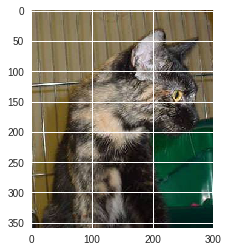

In [0]:
files_valid = os.listdir(f'{PATH}/valid/cats')
img = plt.imread(f'{PATH}/valid/cats/{files_valid[5]}')
plt.imshow(img)

In [0]:
img.shape

(359, 302, 3)

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip /content/drive/'My Drive'/FastAI_DL_V1/test

In [0]:

data = ImageDataBunch.from_folder(PATH, train= 'train', valid = 'valid', test = '../../test', ds_tfms = get_transforms(), size = 224).normalize(imagenet_stats)

In [0]:
arch = models.resnet34
learner = create_cnn(data, arch, pretrained = True, metrics = accuracy)

In [0]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


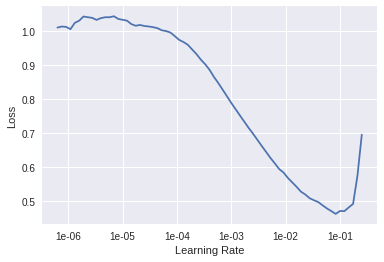

In [0]:
learner.recorder.plot()

In [0]:
learner.fit(2, 0.05)

epoch,train_loss,valid_loss,accuracy
1,0.264096,0.190585,0.927500
2,0.229003,0.139784,0.950000


In [0]:
log_preds = learner.TTA()


In [0]:
preds = np.array(log_preds[1])
probs = log_preds[0]
probs_cat = np.array(np.exp(probs[:,0]))

In [0]:
def random_by_mask(mask): 
 # print(np.where(mask)[0])
  return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace = False)

def random_by_correct(is_correct):
  return random_by_mask((preds == data.valid_ds.y.items) == is_correct)

In [0]:
%matplotlib inline
def plots(imgs, figsize = (12,6), rows = 1, titles = None):
  f = plt.figure(figsize = figsize)
  for i in range(len(imgs)):
    sp = f.add_subplot(rows, len(imgs)//rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize = 16)
    #print(imgs[i].shape)
    imgs[i] = imgs[i].reshape(imgs[i].shape[1], imgs[i].shape[2], 3)
    plt.imshow(imgs[i])
  

In [0]:
def load_images(ds, idx):
  return np.array(ds.x[idx].data)

def plot_vals_with_title(idx, title):
  imgs = [load_images(data.valid_ds, idx1) for idx1 in idx]
 # imgs = [np.array(data.valid_ds.x[idx1]) for idx1 in idx]
  title_probs_cat = np.array([np.array(probs[idx1]) for idx1 in idx])
  print(title)
  return plots(imgs, rows = 1, titles = title_probs_cat, figsize = (16,8)) if len(imgs)>0 else print('Not found')

Correctly classified


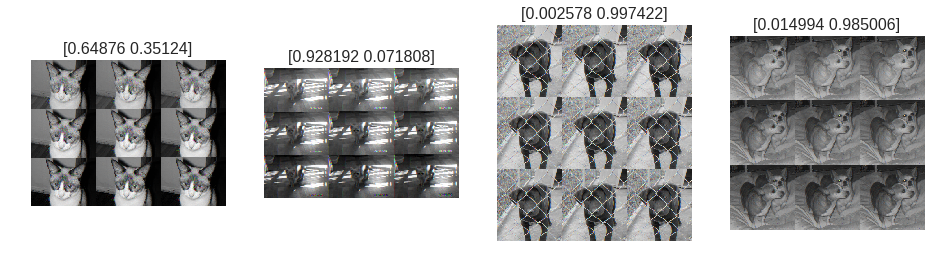

In [0]:
plot_vals_with_title(random_by_correct(True), 'Correctly classified')

In [0]:
#plot_vals_with_title(random_by_correct(False), 'Incorrectly classified')

preds == data.valid_ds.y.items
#ALL PREDICTIONS ARE CORRECT FOR VALIDATION SET

array([ True,  True,  True,  True, ...,  True,  True,  True,  True])

In [0]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs_cat[idxs])[:4]]

def most_by_correct(y, is_correct):
  mult = -1 if (y == 0)==is_correct else 1
  return most_by_mask((((preds == y) == is_correct) & (data.valid_ds.y.items == y)), mult)

Most correct cats


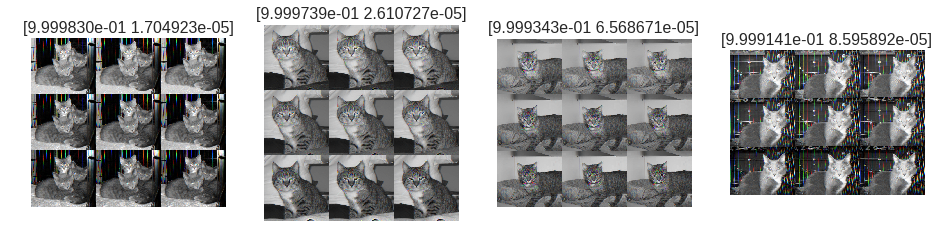

In [0]:
plot_vals_with_title(most_by_correct(0, True), 'Most correct cats')

Most correct dogs


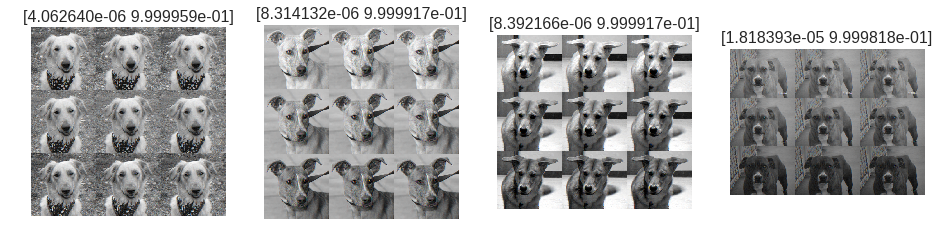

In [0]:
plot_vals_with_title(most_by_correct(1, True), 'Most correct dogs')

Most uncertain


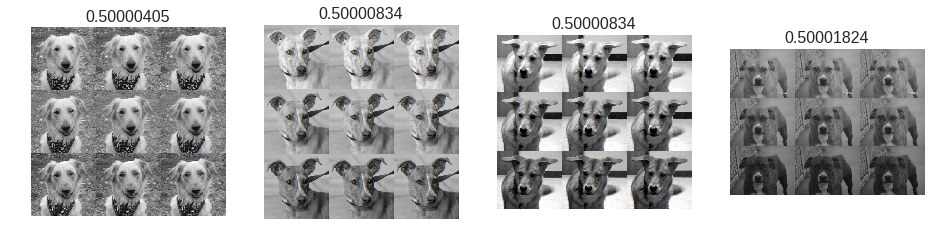

In [0]:
probs = probs_cat-0.5
most_uncertain = np.argsort(np.abs(probs))[:4]
plot_vals_with_title(most_uncertain, 'Most uncertain')

[('cats', 'dogs', 88), ('dogs', 'cats', 8)]

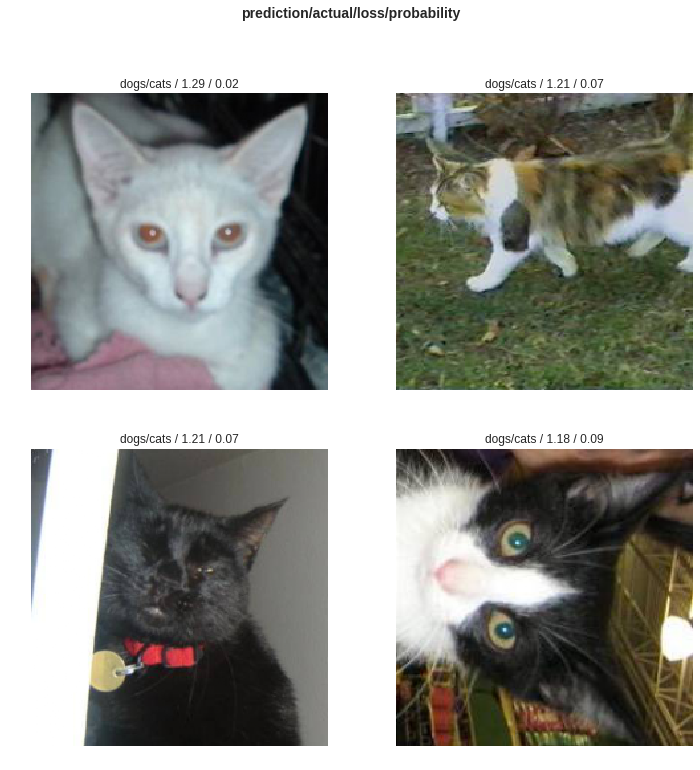

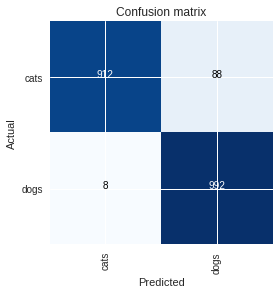

In [0]:
ci = ClassificationInterpretation.from_learner(learner, tta = True)
ci.plot_top_losses(4)
ci.plot_confusion_matrix()
ci.most_confused()

In [0]:
#data.add_tfm(get_transforms())

In [0]:
"""def get_augs():
  x, _ = next(iter(data.train_dl))
  return data.train_ds.transform(x)[1]"""

'def get_augs():\n  x, _ = next(iter(data.train_dl))\n  return data.train_ds.transform(x)[1]'

In [0]:
"""x, _ = next(iter(data.train_dl))
data.train_ds.transform(x)[1]"""

'x, _ = next(iter(data.train_dl))\ndata.train_ds.transform(x)[1]'

In [0]:

"""imgs = np.stack([get_augs() for i in range(6)])
plots(imgs, rows = 2)"""


In [0]:
preds, y = learner.TTA(ds_type = DatasetType.Test)
#FORM THE PREDS AND STORE IN RESULT FILE


#TODO: DEBUG THE ISSUE WITH o.tfm WHY DOES TTA NOT WORK WITH TEST DATA ? Tensor has no attribut tfm for o

In [0]:
pred_classes  = np.argmax(preds, axis = 1)



In [0]:
fnames  = [fname[:-4] for fname in os.listdir('test')]

In [0]:
pred_classes

tensor([1, 1, 0,  ..., 0, 1, 0])

In [0]:
result_df = pd.DataFrame({'id': fnames, 'label': pred_classes}, columns = ['id', 'label'])
result_df.to_csv('result.csv', index = False)

In [0]:
learner.precompute = False
learner.fit(3, 0.02)

In [0]:
learner.save('model_last_layers_trained')

Now we shall unfreeze the earlier layers and retrain them

In [0]:
learner.load('model_last_layers_trained')

In [0]:
learner.unfreeze()


Need to find the new learning rate which is most suitable after unfreezing all layers

In [0]:
learner.lr_find()


epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


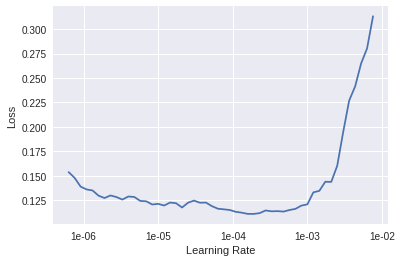

In [0]:
learner.recorder.plot()

In [0]:
lr = np.array([1e-06, 1e-05, 1e-4])
learner.fit_one_cycle(3, lr)
#DOES SGDR with cycle_mult not exist in V1?

epoch,train_loss,valid_loss,accuracy
1,0.100909,0.073612,0.969500
2,0.096692,0.068289,0.972000
3,0.083330,0.067338,0.973000


In [0]:
learner.save('model_all_layers')

In [0]:
learner.load('model_all_layers')

In [0]:
ci_all_layers = ClassificationInterpretation.from_learner(learner, ds_type = Dataset.Valid, tta = True)
ci_all_layers.plot_confusion_matrix()

In [0]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect cats')

NOW BUILDING THIS MODEL FROM SCRATCH, REFER TO NOTEBOOK 2